In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import msprime 
import pickle
import tskit

import pandas as pd
import seaborn as sns


In [2]:
from tslearn.imports import *
from tslearn.helpers import *
from tslearn.networks import *
from tslearn.simulator import *
from tslearn.treesBatchGenerator import *



In [3]:
# make directory tree
cwd = os.getcwd()
sets = ["train","vali","test"]
for subset in ("trees","results"):
    subDir = os.path.join(cwd, subset)
    if not os.path.exists(subDir):
        os.mkdir(subDir)
treeDir = os.path.join(cwd,"trees")
for subset in sets:
    subDir = os.path.join(treeDir,subset)
    if not os.path.exists(subDir):
        os.mkdir(subDir)

In [4]:
    numReps = [int(x) for x in args.nExamples.split(",")]
    mrPrior = [float(x) for x in args.mrPrior.split(",")]
    rrPrior = [float(x) for x in args.rrPrior.split(",")]
    sPrior = [float(x) for x in args.sPrior.split(",")]

    dg_params = {
        'seed':args.seed,
        'N':args.nSamples,
        'Ne':args.Ne,
        'mrPrior':mrPrior,
        'rrPrior':rrPrior,
        'chromLength':args.chromLen,
        's':sPrior,
        'ReLERNN':ReLERNN
              }

In [18]:
# simulate and produce trees
max_table_size = np.zeros(5) #[max_nodes, max_edges, max_sites, max_mutations, max_trees]
for i, subset in enumerate(sets):
    data_generator = SimulatorSweep(**dg_params)
    direc = os.path.join(treeDir,subset)
    table_lens = data_generator.simulateAndProduceTrees(numReps=numReps[i],
            direc=direc,simulator="msprime",nProc=nProc)
    if subset != "test":
        max_table_size = np.maximum(max_table_size, table_lens)
    

Simulate...
Simulate...
Simulate...


In [28]:
# initialize universal batch generator params
train_batch_params = {
    'targetNormalization':'binary',
    'batchSize': 64,
    'frameWidth': 0,
    'center':True,
    'shuffleExamples':True,
    'maxTsTableSize':None,
    'ReLERNN':False
          }
vali_batch_params = copy.deepcopy(train_batch_params)
test_batch_params = copy.deepcopy(train_batch_params)

# define set-specific parameters
targets = [
        "sel_coefs",
        ]

params = [train_batch_params, vali_batch_params, test_batch_params]
for i, subset in enumerate(sets):
    # universal params    
    params[i]['treesDirectory'] = os.path.join(treeDir,subset)
    params[i]['numReps'] = numReps[i]
    info = pickle.load(open(os.path.join(os.path.join(treeDir, subset),"info.p"), "rb"))
    params[i]['rawTargets'] = [info[target] for target in targets]

    # test specific params
    if subset == "test":
        params[i]['batchSize'] = numReps[i]
        params[i]['shuffleExamples'] = False

    #False write batch parameters
    batchParsFILE=os.path.join(treeDir,"{}_batch_params.p".format(subset))
    with open(batchParsFILE, "wb") as fOUT:
        pickle.dump(params[i],fOUT)

## initialize batch generators
train_batch_gen = treesBatchGenerator(**train_batch_params)
vali_batch_gen = treesBatchGenerator(**vali_batch_params)
test_batch_gen = treesBatchGenerator(**test_batch_params)

In [29]:
##########################TRAIN##########################
## define model files
modelFile = os.path.join(cwd,"results","model.json")
weightsFile = os.path.join(cwd,"results","weights.h5")
resultsFile = os.path.join(cwd,"results","model.results")
resultsFig = os.path.join(cwd,"results","results.pdf")

netArchs = {
        "ReLERNN" : RELERNN,
        "LSTM4C_class" : LSTM4C_class,
        "DENSE4_class" : DENSE4_class,
        "CNN2D" : CNN2D,
        }

history = train_model(ModelFuncPointer=netArchs["CNN2D"],
        ModelName="CNN2D",
        targetLabels=targets,
        TrainGenerator=train_batch_gen,
        ValidationGenerator=vali_batch_gen,
        TestGenerator=test_batch_gen,
        numEpochs=10,
        resultsFile=resultsFile,
        network=[modelFile,weightsFile],
        nProc=1,
        gpuID=2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 100, 1)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 193, 93, 64)       4160      
_________________________________________________________________
average_pooling2d_3 (Average (None, 96, 46, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 96, 46, 64)        0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 93, 43, 128)       131200    
_________________________________________________________________
average_pooling2d_4 (Average (None, 46, 21, 128)       0         
_________________________________________________________________
conv1_3 (Conv2D)             (None, 45, 20, 256)       1313

In [39]:
b = train_batch_gen._treesBatchGenerator__data_generation([0, 20])
np.array(b[0]).shape

(2, 100, 100, 1)

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'predictions', 'Y_test', 'name', 'target_labels'])


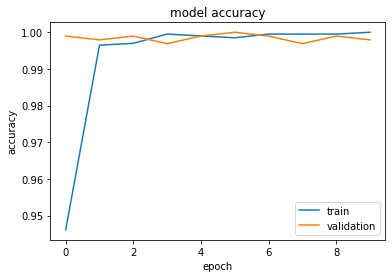

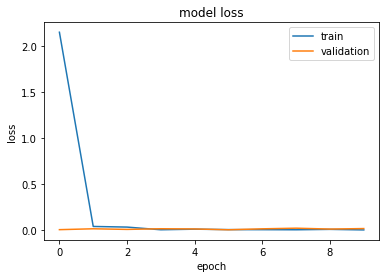

In [32]:
print(history.history.keys())
#  "Accuracy"
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Summary stat sanity checks

we can look at all the examples in the trees directory and calculate things

,pi,tree_n
label,,
0.0,3975.544865,117.448
1.0,807.720353,35.639


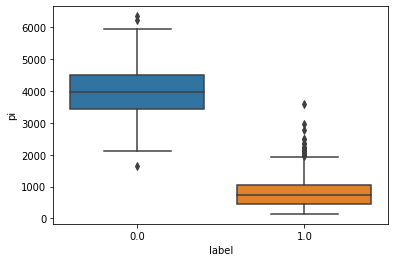

In [7]:
%matplotlib inline
info = pickle.load(open("trees/train/info.p", "rb"))
pis = []
tree_n = []
for i in range(len(info['sel_coefs'])):
    ts = tskit.load(f"trees/train/{i}.trees")
    pis.append(ts.diversity(mode='branch'))
    tree_n.append(ts.num_trees)
pis = np.array(pis)
tree_n = np.array(tree_n)
h = int(len(tree_n) / 2)
labels = np.ones(len(pis))
labels[h:] -= 1

# make dataframe 
fac = pd.DataFrame({'pi':pis, 'tree_n':tree_n,'label':labels})

sns.boxplot(x='label', y='pi', data=fac)
fac.groupby(['label']).mean()

<AxesSubplot:xlabel='label', ylabel='tree_n'>

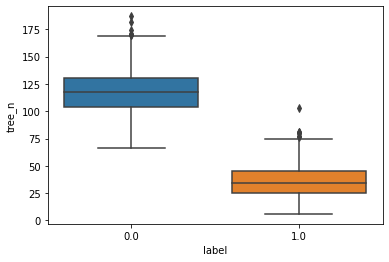

In [8]:
sns.boxplot(x='label', y='tree_n', data=fac)


In [154]:
info = pickle.load(open("trees/train/info.p", "rb"))
tree_n = []
for i in range(len(info['sel_coefs'])):
    ts = tskit.load(f"trees/train/{i}.trees")
    tree_n.append(ts.num_trees)
tree_n = np.array(tree_n)

<ipython-input-155-135c7253a4cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fac.label[h:] -= 1


<AxesSubplot:xlabel='label', ylabel='tree_n'>

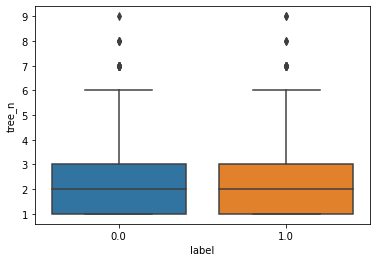

In [155]:
fac = pd.DataFrame({'tree_n':tree_n, 'label':np.ones(len(tree_n))})
fac.label[h:] -= 1
sns.boxplot(x='label', y='tree_n', data=fac)

In [11]:
b = train_batch_gen._treesBatchGenerator__data_generation(np.arange(numReps[0], dtype='int64'))
# np.array(b[1])

In [22]:
h = int(numReps[0] / 2)
avg_sweep = b[0][:h].mean(axis=0)
avg_neut = b[0][h:].mean(axis=0)


In [56]:
mm = np.zeros((3,2))
for i in range(3):
    mm[i,0] = b[0][:,:,:,i].min()
    mm[i,1] = b[0][:,:,:,i].max()

In [58]:
mm

array([[    0.        , 29953.08865896],
       [    0.        ,   174.        ],
       [    0.        , 24778.8100413 ]])

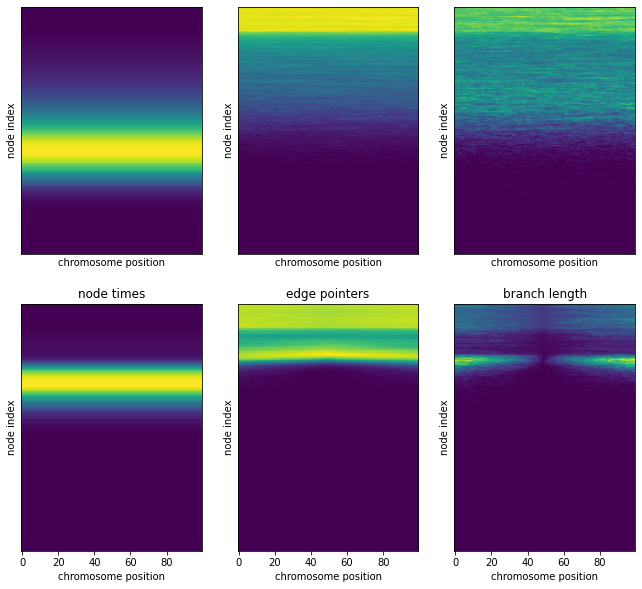

In [65]:
fig, ax = plt.subplots(2,3, figsize=(11, 10))
layer_labels = ['node times', 'edge pointers', 'branch length']
for i in range(3):
    ax[0,i].imshow(avg_neut[:,:,i], aspect='auto')
    ax[0,i].set_yticks([])
    ax[0,i].set_xticks([])

    ax[0,i].set_xlabel('chromosome position')
    ax[0,i].set_ylabel('node index')

    ax[1,i].imshow(avg_sweep[:,:,i], aspect='auto')
    ax[1,i].set_yticks([])
    ax[1,i].set_xlabel('chromosome position')
    ax[1,i].set_ylabel('node index')
    ax[1,i].set_title(layer_labels[i])

plt.savefig("sweep_encodings.png")


[0.]


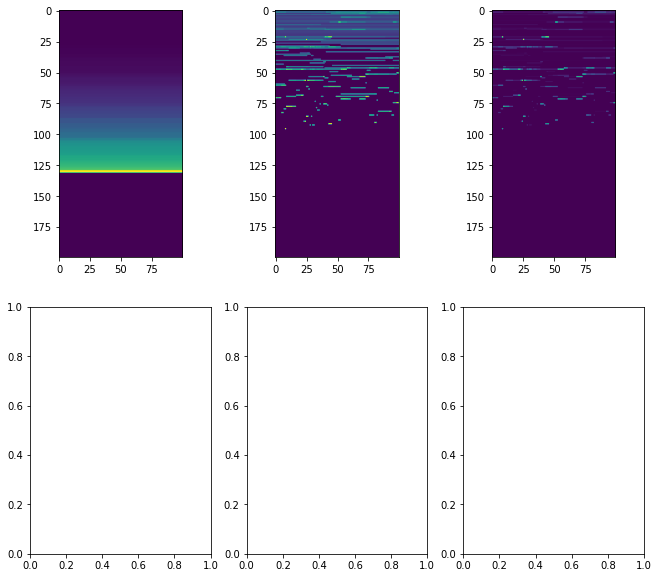

In [19]:
fig, ax = plt.subplots(2,3,figsize=(11, 10))
eg = b[0][-1]
print(b[1][-1])
for i in range(3):
    ax[0,i].imshow(eg[:,:,i])
    #ax[1,i].imshow(eg[:,:,i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


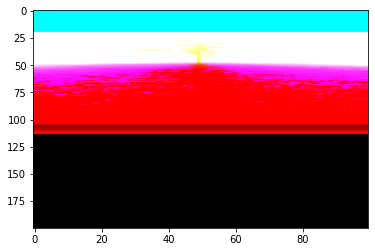

In [26]:
norm = (avg_sweep / np.max(avg_sweep)) * 255
plt.imshow(norm, aspect='auto')

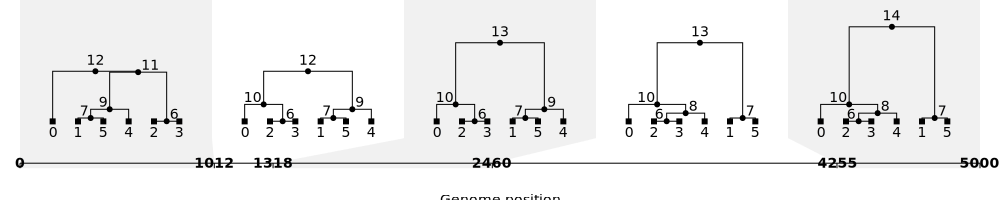

In [163]:
    import msprime
    from IPython.display import SVG, display

    # Simulate an ancestral history for 3 diploid samples under the coalescent
    # with recombination on a 5kb region with human-like parameters.
    ts = msprime.sim_ancestry(
        samples=3,
        recombination_rate=1e-8,
        sequence_length=5000,
        population_size=10000,
        )
    # Visualise the simulated ancestral history.
    SVG(ts.draw_svg())

# Figure for grant

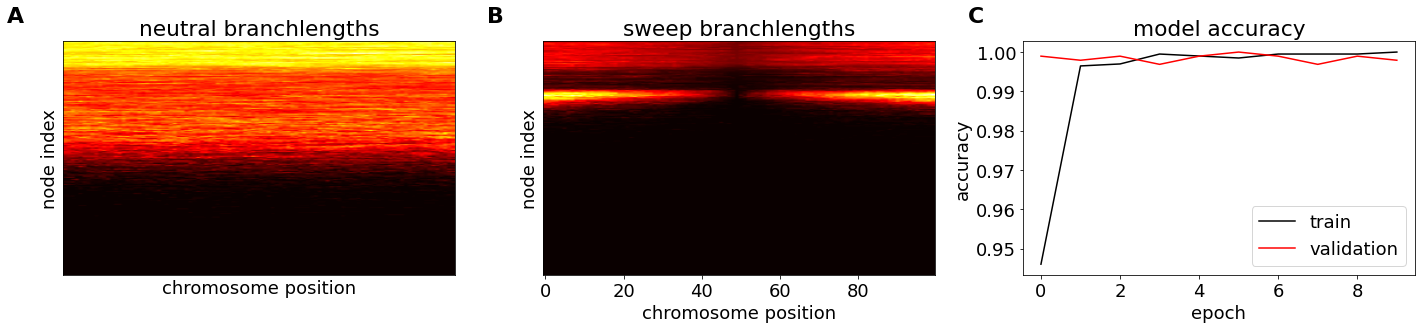

In [67]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(1,3, figsize=(20, 5))
layer_labels = ['node times', 'edge pointers', 'branch length']
i = 2
# neut branch length layer
ax[0].imshow(avg_neut[:,:,i], aspect='auto', cmap='hot')
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlabel('chromosome position')
ax[0].set_ylabel('node index')
ax[0].set_title('neutral branchlengths')
ax[0].text(-0.1, 1.15, "A", transform=ax[0].transAxes,
      fontsize=22, fontweight='bold', va='top', ha='right')

# sweep branch length layer
ax[1].imshow(avg_sweep[:,:,i], aspect='auto', cmap='hot')
ax[1].set_yticks([])
ax[0].set_xticks([])
ax[1].set_xlabel('chromosome position')
ax[1].set_ylabel('node index')
ax[1].set_title('sweep branchlengths')
ax[1].text(-0.1, 1.15, "B", transform=ax[1].transAxes,
      fontsize=22, fontweight='bold', va='top', ha='right')
#Accuracy
ax[2].plot(history.history['acc'], color='black')
ax[2].plot(history.history['val_acc'], color='red')
ax[2].set_title('model accuracy')
ax[2].set_ylabel('accuracy')
ax[2].set_xlabel('epoch')
ax[2].legend(['train', 'validation'], loc='lower right')
ax[2].text(-0.1, 1.15, "C", transform=ax[2].transAxes,
      fontsize=22, fontweight='bold', va='top', ha='right')
# "Loss"
#ax[3].plot(history.history['loss'])
#ax[3].plot(history.history['val_loss'])
#ax[3].set_title('model loss')
#ax[3].set_ylabel('loss')
#ax[3].set_xlabel('epoch')
#ax[3].legend(['train', 'validation'], loc='upper right')
plt.tight_layout()
plt.savefig("sa3_grant_fig.pdf")